Using device: cpu


c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
C:\Users

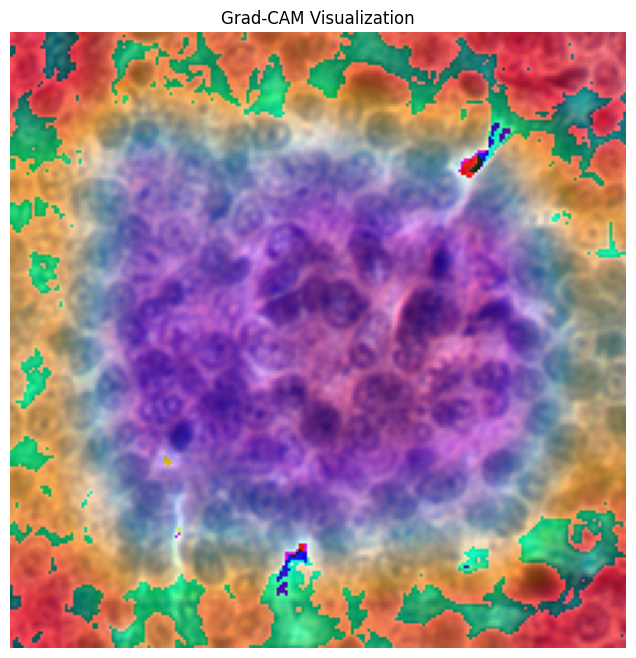

In [1]:
# notebooks/gradcam_visualization.ipynb

# --- Install required libraries if needed ---
# !pip install torch torchvision matplotlib opencv-python

# --- Imports ---
import torch
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("../scripts")

from data_loader import load_tile_dataset

# --- Load Data ---
processed_tiles_folder = "../data/processed_tiles/"
batch_size = 1  # GradCAM is usually done 1 image at a time
image_size = 224

_, val_loader, class_names = load_tile_dataset(
    data_dir=processed_tiles_folder,
    batch_size=batch_size,
    shuffle=False,
    image_size=image_size,
    val_split=0.2
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Trained Model ---
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

model.load_state_dict(torch.load("../data/models/trained_resnet18.pth", map_location=device))
model.eval()

# --- Define GradCAM Helper Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        output = self.model(input_image)

        if target_class is None:
            target_class = torch.argmax(output)

        loss = output[:, target_class]
        self.model.zero_grad()
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        activations = self.activations.detach()

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

# --- Pick a sample image from validation ---
sample_images, sample_labels = next(iter(val_loader))
sample_image = sample_images[0].unsqueeze(0).to(device)

# --- Apply GradCAM ---
target_layer = model.layer4[1].conv2  # Deep last convolution
gradcam = GradCAM(model, target_layer)

heatmap = gradcam.generate(sample_image)

# --- Visualize Heatmap Over Image ---
def show_gradcam_on_image(img, heatmap):
    img = img.squeeze().cpu().numpy().transpose((1,2,0))
    img = (img * 0.5 + 0.5) * 255  # Unnormalize
    img = np.uint8(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * 0.4 + img

    plt.figure(figsize=(8,8))
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

show_gradcam_on_image(sample_image, heatmap)


c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


⚡ Computing SHAP values (this might take a few minutes)...


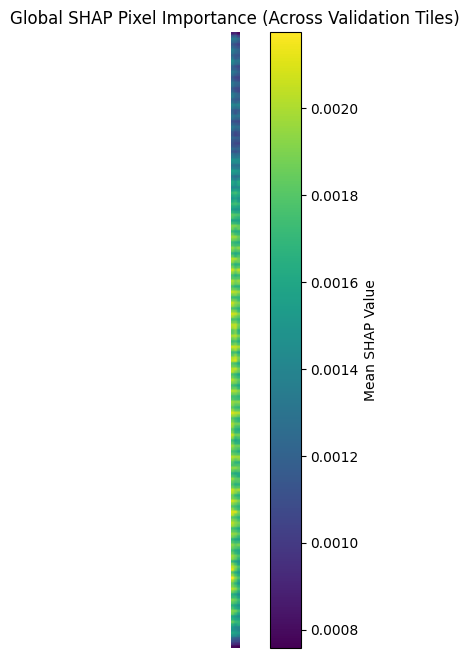

C:\Users\frank\AppData\Local\Temp\ipykernel_29604\184133021.py:109: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=background.cpu().numpy(), feature_names=["R", "G", "B"])


MemoryError: Unable to allocate 3.30 TiB for an array with shape (224, 224, 3, 20, 224, 224, 3) and data type float64

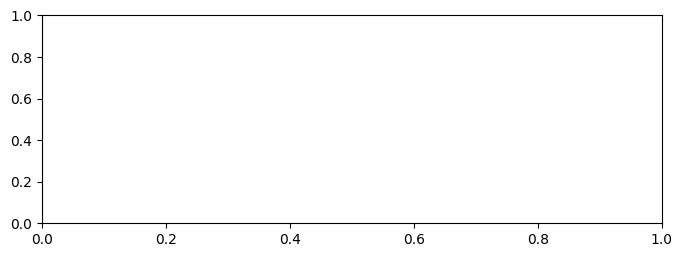

: 

In [ ]:
# notebooks/shap_visualization.ipynb

# --- Install required libraries if needed ---

# --- Imports ---
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import shap
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts")

from data_loader import load_tile_dataset

# --- Load Data ---
processed_tiles_folder = "../data/processed_tiles/"
batch_size = 1
image_size = 224

_, val_loader, class_names = load_tile_dataset(
    data_dir=processed_tiles_folder,
    batch_size=batch_size,
    shuffle=False,
    image_size=image_size,
    val_split=0.2
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Trained Model ---
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

model.load_state_dict(torch.load("../data/models/trained_resnet18.pth", map_location=device))
model.eval()

# --- Fix in-place ReLU for SHAP ---
def recursive_relu_inplace_false(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            module.inplace = False
        else:
            recursive_relu_inplace_false(module)

recursive_relu_inplace_false(model)

# --- Prepare a batch of validation images for SHAP
background = []
samples = []
labels = []

for i, (inputs, lbls) in enumerate(val_loader):
    inputs = inputs.to(device)
    background.append(inputs)
    labels.append(lbls)

    if len(background) >= 20:  # Use 20 samples for SHAP (can adjust if you want)
        break

background = torch.cat(background, dim=0)

# --- Define a SHAP wrapper
class ResNetWrapper(nn.Module):
    def __init__(self, model):
        super(ResNetWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

wrapped_model = ResNetWrapper(model)

# --- Use SHAP DeepExplainer
explainer = shap.DeepExplainer(wrapped_model, background)

# Note: SHAP expects float32
background = background.float()

explainer = shap.GradientExplainer(wrapped_model, background)

print("⚡ Computing SHAP values (this might take a few minutes)...")
shap_values = explainer.shap_values(background)

# --- Summarize Global Importance
# shap_values will have one array per class
# We'll just visualize for one class (e.g., overall first)

shap_numpy = np.stack([np.abs(shap_val).mean(axis=0) for shap_val in shap_values])

# Global SHAP Summary
mean_shap = shap_numpy.mean(axis=0)  # Mean over samples
mean_shap = mean_shap.transpose((1,2,0))  # [H, W, C]

# Sum over color channels
mean_shap_gray = mean_shap.mean(axis=-1)

plt.figure(figsize=(8,8))
plt.imshow(mean_shap_gray, cmap='viridis')
plt.title("Global SHAP Pixel Importance (Across Validation Tiles)")
plt.axis('off')
plt.colorbar(label="Mean SHAP Value")
plt.show()

shap.summary_plot(shap_values, features=background.cpu().numpy(), feature_names=["R", "G", "B"])
plt.savefig("outputs/shap_summary.png", bbox_inches='tight')
